## Predicting age from the image - CNN & Transfer Learning (ResNet50) models

The main objective of this project is to train images of people to predict their age.

In [ ]:
# imports
import numpy as np
import random
import os
import time
from pathlib import Path
from glob import glob
import pathlib
import pandas as pd
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import transform
import cv2

# tensorflow & keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = Path(r'/content/')
MY_GOOGLE_DRIVE = ROOT/'drive/My Drive/project'

### Data loading and pre-processing

Data Source: Kaggle Datasets https://www.kaggle.com/frabbisw/facial-age  
Size: 439 MB

In [ ]:
FACE_AGE_DATA = f"{MY_GOOGLE_DRIVE}/face_age/"
folders = glob(FACE_AGE_DATA + '*')

ages_dict = {}
for dirname in folders:
    ages_dict[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

ages_dict = dict(sorted(ages_dict.items()))
print('Age labels:', ages_dict.keys())
print('Number of distinct age labels: ', len(ages_dict.keys()))

Age labels: dict_keys(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110'])
Number of distinct age labels:  99


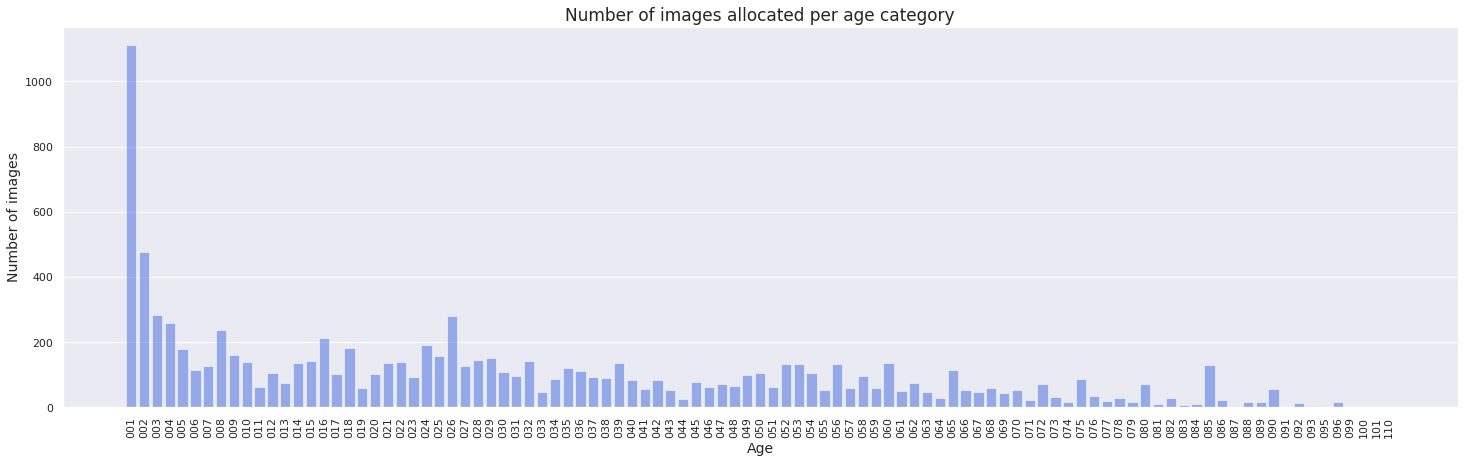

In [ ]:
# ditribution of images per age category
plt.figure(figsize=(25, 7))
plt.title('Number of images allocated per age category', fontsize=17)
plt.bar(list(ages_dict.keys()), ages_dict.values(), color='royalblue', alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of images', fontsize=14)
plt.grid(axis='x')
plt.show()

In [ ]:
# read, resize and normalize images
images_age = []

for file in os.listdir(FACE_AGE_DATA):
  name = file.rsplit('/')[-1]
  label = int(name[-3:])
  path = os.path.join(FACE_AGE_DATA, file)

  for img in os.listdir(path):
    if pathlib.Path(img).suffix == '.png':
      image = load_img(os.path.join(path, img),
                       grayscale=False,
                       color_mode='rgb',
                       target_size=(100,100))
      image = img_to_array(image)
      image = image/255.0 # normalize
      images_age.append([image, label])

In [ ]:
data,label = zip(*images_age)

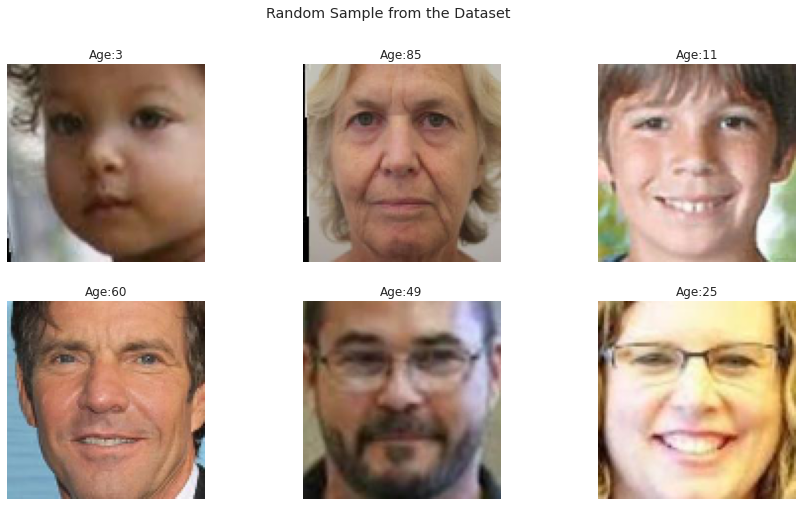

In [ ]:
# generate random indices to draw a sample from dataset
n = random.sample(range(0, len(data)), 6)

fig = plt.figure(figsize=(15,8))
fig.suptitle('Random Sample from the Dataset')
for i, j in enumerate(n):
  axs = fig.add_subplot(2,3,i+1)
  axs.set_title(f"Age:{ label[j]}")
  plt.imshow(data[j])
  plt.axis('off')

plt.show()

In [ ]:
# encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(np.array(label)).reshape(len(label), 1)

In [ ]:
# one-hot encodeding
unique_cat = len(np.unique(labels))
labels = to_categorical(labels, num_classes=unique_cat, dtype='float32')

In [ ]:
# convert to np arrays
data=np.array(data)
labels=np.array(labels).astype('float32')

In [ ]:
# split into train, val, and test data sets
x,test_x,y,test_y=train_test_split(data,labels,test_size=0.20,random_state=42)
train_x,val_x,train_y,val_y=train_test_split(x,y,test_size=0.25,random_state=42)

In [ ]:
print('Train sets dimentions: ', train_x.shape, train_y.shape)
print('Validation sets dimentions: ', val_x.shape, val_y.shape)
print('Test sets dimentions: ', test_x.shape, test_y.shape)

Train sets dimentions:  (5866, 100, 100, 3) (5866, 99)
Validation sets dimentions:  (1956, 100, 100, 3) (1956, 99)
Test sets dimentions:  (1956, 100, 100, 3) (1956, 99)


### CNN model

In [ ]:
def evaluation_plot(history, title:str=''):
  """Evalutating training results"""
  # convert training results into df and plot train vs. validation
  results = pd.DataFrame(history.history)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

  ax1.plot(results.index, results.accuracy, label='train', marker='o', color='royalblue', lw=2)
  ax1.plot(results.index, results.val_accuracy, label='validation', marker='o', color='orange', lw=2)
  ax1.set_title('Accuracy', fontsize=15)
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('validation accuracy %')
  ax1.grid(True)
  ax1.legend()

  ax2.plot(results.index, results.loss, label='train', marker='o', color='royalblue', lw=2)
  ax2.plot(results.index, results.val_loss, label='validation', marker='o', color='orange', lw=2)
  ax2.set_title('Loss', fontsize=15)
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('validation loss')
  ax2.grid(True)
  ax2.legend()

  fig.suptitle(title, fontsize=15)

Build base model

In [ ]:
name = "CNN_classifier1"
input_shape = [100, 100, 3]
learning_rate = 0.001

# kernel_regularizer=regul
#build model
model1 = Sequential(name=name, layers= [
    # 1st Convolution Block
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.2),
    # 2nd Convolution Block
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2, 2), strides=2),
    # 3rd Convolution Block
    Conv2D(256, (5,5), padding='same', activation='relu'),

    # Dense layers
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(99, activation='softmax'),  # Output layer
    ])

# Optimizer
optimizer = Adam(learning_rate=learning_rate)
#compile model
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

display(model1.summary())
K.clear_session()

start_time = time.time()
result1 = model1.fit(train_x, train_y,
                    epochs=35,
                    batch_size=64,
                    validation_data=(val_x, val_y),
                    verbose=1,
                    callbacks=None)

execution_time = (time.time() - start_time)/60.0
print('Training execution time (mins): {:.2f}'.format(execution_time))

model1.save(MY_GOOGLE_DRIVE/model1.name)

Model: "CNN_classifier1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 256)   

None

Epoch 1/35
92/92 [==============================] - 5s 40ms/step - loss: 4.2970 - accuracy: 0.0968 - val_loss: 4.0182 - val_accuracy: 0.1299
Epoch 2/35
92/92 [==============================] - 3s 36ms/step - loss: 3.7562 - accuracy: 0.1297 - val_loss: 3.5769 - val_accuracy: 0.1391
Epoch 3/35
92/92 [==============================] - 3s 36ms/step - loss: 3.4485 - accuracy: 0.1562 - val_loss: 3.3596 - val_accuracy: 0.1713
Epoch 4/35
92/92 [==============================] - 3s 36ms/step - loss: 3.2386 - accuracy: 0.1807 - val_loss: 3.2622 - val_accuracy: 0.1667
Epoch 5/35
92/92 [==============================] - 3s 36ms/step - loss: 3.0469 - accuracy: 0.2000 - val_loss: 3.2075 - val_accuracy: 0.1544
Epoch 6/35
92/92 [==============================] - 3s 36ms/step - loss: 2.8483 - accuracy: 0.2351 - val_loss: 3.2321 - val_accuracy: 0.1830
Epoch 7/35
92/92 [==============================] - 3s 36ms/step - loss: 2.6291 - accuracy: 0.2767 - val_loss: 3.3557 - val_accuracy: 0.1524
Epoch 8/35
92

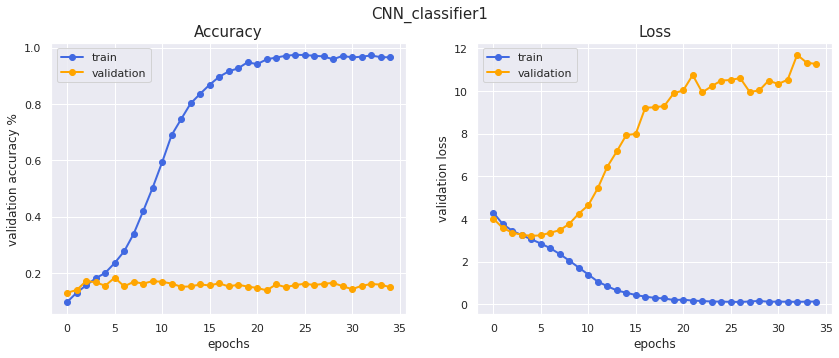

In [ ]:
evaluation_plot(result1, model1.name)

We experimented wit different number of Dense and Conv layers and sizes.  
In addition, to adding one more Dense and Conve layer to the next trial, we increased batch size and decrease learning rate.

In [ ]:
name = "CNN_classifier2"
input_shape = [100, 100, 3]
learning_rate = 0.0001

#build model
model2 = Sequential(name=name, layers= [
    # 1st Convolution Block
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape),
    MaxPool2D((2, 2), strides=2),
    # 2nd Convolution Block
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2, 2), strides=2),
    # 3rd Convolution Block
    Conv2D(256, (5,5), padding='same', activation='relu'),
    MaxPool2D((2, 2), strides=2),
    # 4th Convolution Block
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPool2D((2, 2), strides=2),

    # Dense layers
    Flatten(),
    Dense(units=256, activation='relu'),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(units=512, activation='relu'),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(units=512, activation='relu'),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(99, activation='softmax'),  # Output layer
    ])

# Optimizer
optimizer = Adam(learning_rate=learning_rate)
#compile model
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

display(model2.summary())
K.clear_session()

start_time = time.time()
result2 = model2.fit(train_x, train_y,
                    epochs=35,
                    batch_size=128,
                    validation_data=(val_x, val_y),
                    verbose=1,
                    callbacks=None)


execution_time = (time.time() - start_time)/60.0
print('Training execution time (mins): {:.2f}'.format(execution_time))

model2.save(MY_GOOGLE_DRIVE/model2.name)

Model: "CNN_classifier2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 256)       819456    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 256)  

None

Epoch 1/35
46/46 [==============================] - 4s 74ms/step - loss: 4.3540 - accuracy: 0.0827 - val_loss: 4.1195 - val_accuracy: 0.1196
Epoch 2/35
46/46 [==============================] - 3s 63ms/step - loss: 4.1423 - accuracy: 0.1072 - val_loss: 4.0266 - val_accuracy: 0.1196
Epoch 3/35
46/46 [==============================] - 3s 62ms/step - loss: 3.9984 - accuracy: 0.1065 - val_loss: 3.7515 - val_accuracy: 0.1380
Epoch 4/35
46/46 [==============================] - 3s 62ms/step - loss: 3.7386 - accuracy: 0.1168 - val_loss: 3.5828 - val_accuracy: 0.1442
Epoch 5/35
46/46 [==============================] - 3s 63ms/step - loss: 3.5786 - accuracy: 0.1347 - val_loss: 3.4363 - val_accuracy: 0.1503
Epoch 6/35
46/46 [==============================] - 3s 62ms/step - loss: 3.4398 - accuracy: 0.1504 - val_loss: 3.3423 - val_accuracy: 0.1687
Epoch 7/35
46/46 [==============================] - 3s 62ms/step - loss: 3.3599 - accuracy: 0.1544 - val_loss: 3.2237 - val_accuracy: 0.1805
Epoch 8/35
46

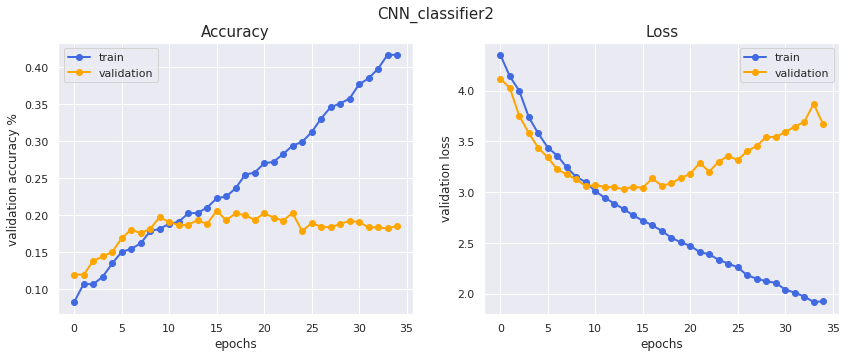

In [ ]:
evaluation_plot(result2, model2.name)

Adding Dropout rates and L1 & L2 regularization to penalize weights. Also, decreasing learning rate.   
We have tried other optimizers, but Adam performs best in our case.

In [ ]:
name = "CNN_classifier"
input_shape = [100, 100, 3]
learning_rate = 0.001

regul = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)  # L1 + L2 penalties
# kernel_regularizer=regul
#build model
model3 = Sequential(name=name, layers= [
    # 1st Convolution Block
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape),
    # BatchNormalization(),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.2),
    # 2nd Convolution Block
    Conv2D(128, (3,3), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.2),
    # 3rd Convolution Block
    Conv2D(256, (5,5), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.2),
    # 4th Convolution Block
    Conv2D(512, (3,3), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),

    # Dense layers
    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer=regul),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(units=512, activation='relu', kernel_regularizer=regul),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(units=512, activation='relu', kernel_regularizer=regul),
    # BatchNormalization(),
    Dropout(0.25),
    Dense(99, activation='softmax'),  # Output layer
    ])

# Optimizer
optimizer = Adam(learning_rate=learning_rate)
#compile model
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

display(model3.summary())
K.clear_session()

start_time = time.time()
result3 = model3.fit(train_x, train_y,
                    epochs=35,
                    batch_size=128,
                    validation_data=(val_x, val_y),
                    verbose=1,
                    callbacks=None)
                    #callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)])

execution_time = (time.time() - start_time)/60.0
print('Training execution time (mins): {:.2f}'.format(execution_time))

model3.save(MY_GOOGLE_DRIVE/model3.name)

Model: "CNN_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 128)    

None

Epoch 1/35
46/46 [==============================] - 4s 75ms/step - loss: 7.0916 - accuracy: 0.0922 - val_loss: 5.5583 - val_accuracy: 0.1196
Epoch 2/35
46/46 [==============================] - 3s 66ms/step - loss: 5.1861 - accuracy: 0.1076 - val_loss: 4.9857 - val_accuracy: 0.1196
Epoch 3/35
46/46 [==============================] - 3s 67ms/step - loss: 4.7566 - accuracy: 0.1071 - val_loss: 4.5442 - val_accuracy: 0.1196
Epoch 4/35
46/46 [==============================] - 3s 67ms/step - loss: 4.4715 - accuracy: 0.1142 - val_loss: 4.2209 - val_accuracy: 0.1391
Epoch 5/35
46/46 [==============================] - 3s 67ms/step - loss: 4.2123 - accuracy: 0.1248 - val_loss: 4.0464 - val_accuracy: 0.1483
Epoch 6/35
46/46 [==============================] - 3s 66ms/step - loss: 4.0572 - accuracy: 0.1369 - val_loss: 3.9067 - val_accuracy: 0.1616
Epoch 7/35
46/46 [==============================] - 3s 66ms/step - loss: 3.9271 - accuracy: 0.1432 - val_loss: 3.8083 - val_accuracy: 0.1636
Epoch 8/35
46

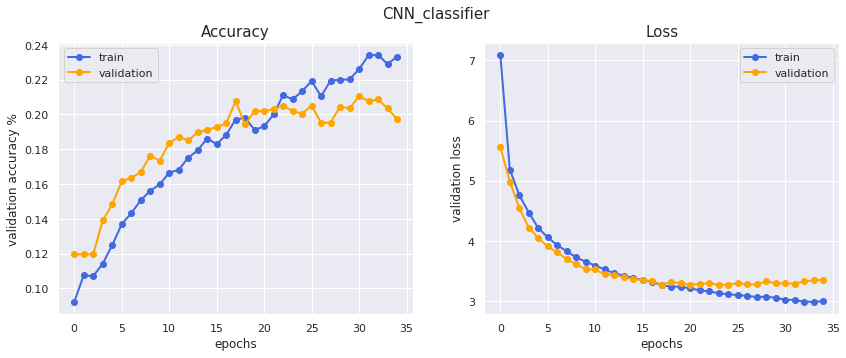

In [ ]:
evaluation_plot(result3, model3.name)

In [ ]:
K.clear_session()
# evaluate accuracy on the test set
acc = model3.evaluate(test_x, test_y, verbose=1)

62/62 [==============================] - 1s 8ms/step - loss: 3.3629 - accuracy: 0.2147


#### CNN - Test Data Predictions

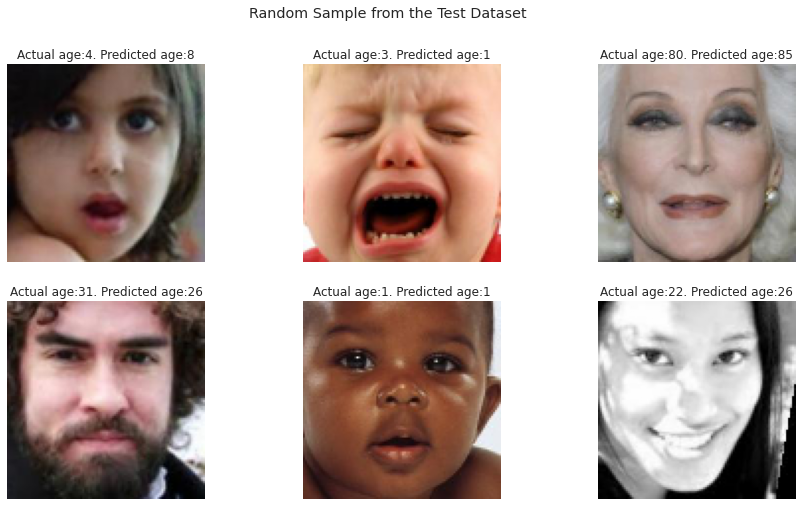

In [ ]:
# generate random indices to draw a sample from dataset
n = random.sample(range(0, len(test_x)), 6)

fig = plt.figure(figsize=(15,8))
fig.suptitle('Random Sample from the Test Dataset')
orig_label = np.argmax(test_y, axis=1)
orig_label = label_encoder.inverse_transform(orig_label)
for i, j in enumerate(n):
  axs = fig.add_subplot(2,3,i+1)

  im = np.expand_dims(test_x[j], axis=0)
  pred = model3.predict(im)
  l = np.argmax(pred, axis=1)
  new_label = int(label_encoder.inverse_transform(l))
  # pred_age_ = np.round(np.sum(pred * np.unique(label), axis=1))

  axs.set_title(f"Actual age:{orig_label[j]}. Predicted age:{new_label}")
  plt.imshow(test_x[j])
  plt.axis('off')

plt.show()

The 6 random samples obtained from the test data is giving us really good predictions. We're assuming that there are chances of misclassification for black and white images.

In [ ]:
from keras.models import load_model
# model = load_model('model.hdf5')
cnn_model = load_model(MY_GOOGLE_DRIVE/'CNN_classifier')

In [ ]:
image_1 = face_recognition.load_image_file('Tom_Hanks.PNG') # actual age 65
image_1 = image_1/255
image_1 = transform.resize(image_1, (100, 100, 3))
image_1 = np.expand_dims(image_1, axis=0)
proba_ = cnn_model.predict(image_1)
pred_age1 = int(np.round(np.sum(proba_ * np.unique(label), axis=1)))
tensor_to_img1 = np.squeeze(image_1)

Predicted age range:  73


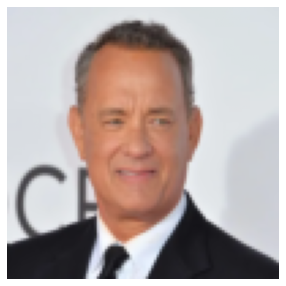

In [ ]:
fig = plt.figure(figsize=(5,5))
print('Predicted age range: ',pred_age1)
plt.imshow(tensor_to_img1)
plt.axis('off')
plt.show()

The actual age of Tom Hanks, in the above image, is 65 and our model predicted 73 here. We think that this prediction is not bad and that the inaccuracy mighht be because of the quality of the image.

### Transfer learning - pre-trained ResNet50 model

https://keras.io/api/applications/resnet/

#### Data Preparation

We have decided to group ages into a few buckets to have fewer categories.

In [ ]:
age_splits = [1,5,11,17,22,29,35,42,50,60,70,85,111]
age_bucket = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]

age_ranges = {}
for age_range in age_bucket:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_ranges[f'{age_range[0]}-{age_range[-1]}'] = total

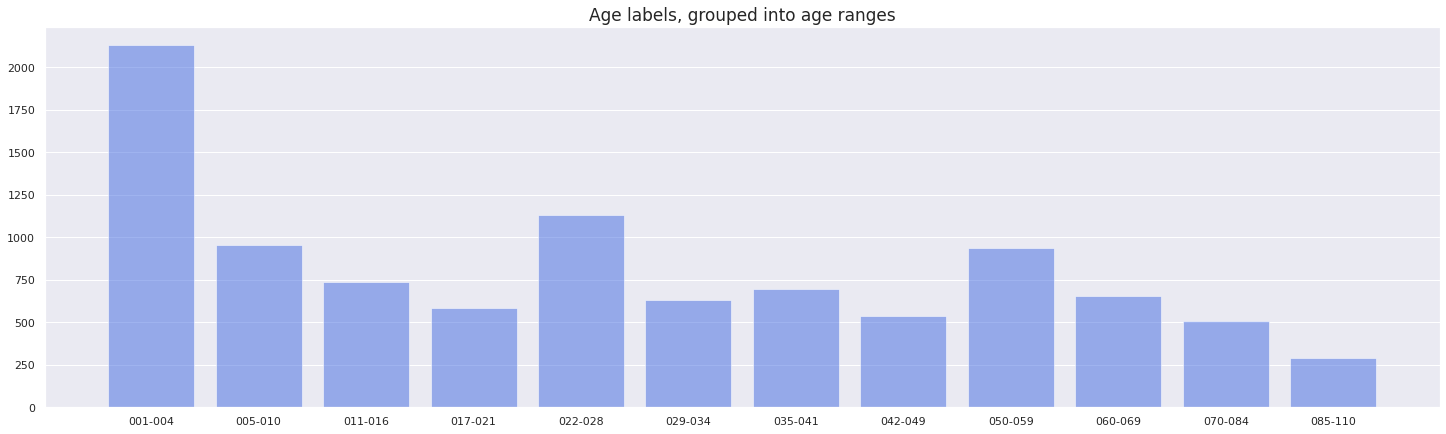

In [ ]:
#  plot distribution
plt.figure(figsize=(25, 7))
plt.title('Age labels, grouped into age ranges', fontsize=17)
plt.bar(list(age_ranges.keys()), age_ranges.values(), color='royalblue', alpha=0.5)
plt.grid(axis='x')
plt.show()

In [ ]:
# train/test split 80/20
train_sample_size = int(min(age_ranges.values()) * 0.8)

# create train/test directory
train_dir = './train'
test_dir = './test'
rmtree(train_dir, ignore_errors=True)
rmtree(test_dir, ignore_errors=True)

# generate the directory names
filename_dict = dict()

for range_age in age_bucket:
  path_test = Path(f"{test_dir}/{range_age[0]}-{range_age[-1]}")
  path_test.mkdir(parents=True, exist_ok=True)
  path_train = Path(f"{train_dir}/{range_age[0]}-{range_age[-1]}")
  path_train.mkdir(parents=True, exist_ok=True)
  filename = list()
  for age in range_age:
    filename.extend(glob(FACE_AGE_DATA + age + '/*'))
  filename_dict[f"{range_age[0]}-{range_age[-1]}"] = filename

train_files = glob(train_dir + '/*/*.png')
test_files = glob(test_dir + '/*/*.png')

In [ ]:
# Copy 80%/20% of data into sample train and test folders
for range_age in filename_dict:
    age_sample = random.sample(filename_dict[range_age], min(age_ranges.values()))
    train_filenames = age_sample[:train_sample_size]
    for f in train_filenames:
        copyfile(f, f"{train_dir}/{range_age}/{f.split('/')[-1]}")

    test_filenames = age_sample[train_sample_size:]
    for f in test_filenames:
        copyfile(f, f"{test_dir}/{range_age}/{f.split('/')[-1]}")


In [ ]:
# pre-process/data augmentation for train data
train_gen = ImageDataGenerator(rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_directory(
                                train_dir,
                                target_size=(100,100),
                                shuffle=True,
                                batch_size=128,
                                class_mode='sparse')

Found 2916 images belonging to 12 classes.


In [ ]:
# generate valuation data as train set
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = val_gen.flow_from_directory(test_dir,
                                              shuffle=False,
                                              target_size=(100,100),
                                              batch_size=128,
                                              class_mode='sparse')

Found 528 images belonging to 12 classes.


#### Loading and updating pre-trained model

In [ ]:
# load pre-trained model
from tensorflow.keras.applications import ResNet50
base_model_res50 = ResNet50(input_shape=(100, 100, 3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# freeze weights of pre-trained model
for layer in base_model_res50.layers[:-8]:
  layer.trainable = False

In [ ]:
# add 1 additional fully connected layer
name = "RsNet50_extend"
base_model = Sequential(name=name)
base_model.add(base_model_res50)
base_model.add(Flatten())
base_model.add(Dropout(0.2))
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(0.1))
base_model.add(Dense(12, activation='softmax'))

base_model.summary()

Model: "RsNet50_extend"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_18 (Dropout)        (None, 32768)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 12)                6156      
                                                                 
Total params: 40,371,596
Trainable params: 20,199,43

In [ ]:
# compile model
# learning_rate=0.001
optimizer = Adam()
base_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [ ]:
# fit extended model
result_res50 = base_model.fit(train_generator, validation_data=valid_generator,
                              epochs=20,
                              verbose=1,
                              callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)])

execution_time = (time.time() - start_time)/60.0
print('Training execution time (mins): {:.2f}'.format(execution_time))

base_model.save(MY_GOOGLE_DRIVE/base_model.name)

Epoch 1/20
23/23 [==============================] - 17s 627ms/step - loss: 2.3090 - accuracy: 0.2462 - val_loss: 1.6878 - val_accuracy: 0.3504
Epoch 2/20
23/23 [==============================] - 13s 558ms/step - loss: 1.7081 - accuracy: 0.3501 - val_loss: 1.6138 - val_accuracy: 0.3504
Epoch 3/20
23/23 [==============================] - 13s 560ms/step - loss: 1.6567 - accuracy: 0.3789 - val_loss: 1.6394 - val_accuracy: 0.3542
Epoch 4/20
23/23 [==============================] - 13s 559ms/step - loss: 1.5810 - accuracy: 0.3920 - val_loss: 1.6161 - val_accuracy: 0.3731
Epoch 5/20
23/23 [==============================] - 13s 551ms/step - loss: 1.5533 - accuracy: 0.4071 - val_loss: 1.6495 - val_accuracy: 0.3598
Epoch 6/20
23/23 [==============================] - 13s 559ms/step - loss: 1.5223 - accuracy: 0.3975 - val_loss: 1.5800 - val_accuracy: 0.3750
Epoch 7/20
23/23 [==============================] - 13s 553ms/step - loss: 1.4902 - accuracy: 0.4201 - val_loss: 1.5608 - val_accuracy: 0.3731

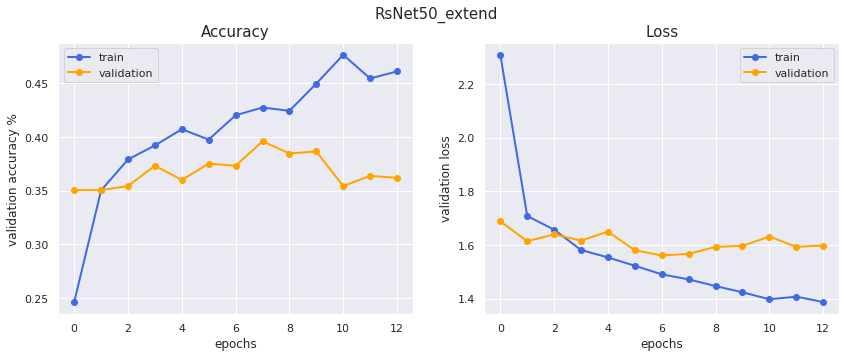

In [ ]:
evaluation_plot(result_res50, base_model.name)

In [ ]:
# add 2 additional fully connected layers
name = "RsNet50_extend"
base_model = Sequential(name=name)
base_model.add(base_model_res50)
base_model.add(Flatten())
base_model.add(Dropout(0.2))
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(0.1))
base_model.add(Dense(256, activation='relu'))
base_model.add(Dropout(0.1))
base_model.add(Dense(12, activation='softmax'))

base_model.summary()

Model: "RsNet50_extend"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_20 (Dropout)        (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_22 (Dropout)        (None, 256)            

In [ ]:
# compile model
# learning_rate=0.001
optimizer = Adam()
base_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [ ]:
# fit extended model
start_time = time.time()
result_res50 = base_model.fit(train_generator, validation_data=valid_generator,
                              epochs=20,
                              steps_per_epoch=len(train_files)//128,
                              validation_steps=len(test_files)//128,
                              verbose=1,
                              callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)])

execution_time = (time.time() - start_time)/60.0
print('Training execution time (mins): {:.2f}'.format(execution_time))

base_model.save(MY_GOOGLE_DRIVE/base_model.name)

Epoch 1/20
22/22 [==============================] - 20s 744ms/step - loss: 4.6194 - accuracy: 0.2188 - val_loss: 1.9681 - val_accuracy: 0.2441
Epoch 2/20
22/22 [==============================] - 15s 664ms/step - loss: 1.8544 - accuracy: 0.3278 - val_loss: 1.8202 - val_accuracy: 0.3047
Epoch 3/20
22/22 [==============================] - 15s 663ms/step - loss: 1.6741 - accuracy: 0.3777 - val_loss: 1.7246 - val_accuracy: 0.3711
Epoch 4/20
22/22 [==============================] - 15s 661ms/step - loss: 1.5859 - accuracy: 0.3877 - val_loss: 1.6256 - val_accuracy: 0.3965
Epoch 5/20
22/22 [==============================] - 14s 656ms/step - loss: 1.5651 - accuracy: 0.3992 - val_loss: 1.6152 - val_accuracy: 0.3809
Epoch 6/20
22/22 [==============================] - 15s 666ms/step - loss: 1.5215 - accuracy: 0.4118 - val_loss: 1.5941 - val_accuracy: 0.4082
Epoch 7/20
22/22 [==============================] - 15s 659ms/step - loss: 1.4679 - accuracy: 0.4444 - val_loss: 1.6273 - val_accuracy: 0.4082

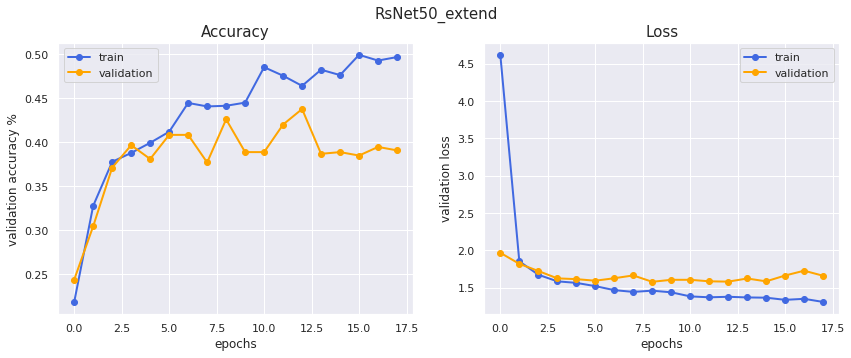

In [ ]:
evaluation_plot(result_res50, base_model.name)

#### ResNet50 - Test Data Predictions

In [ ]:
# create predictions for test dataset
valid_generator.reset()
test_gen_pred = base_model.predict(valid_generator)
predicted_class_indices=np.argmax(test_gen_pred,axis=1)
labels=(valid_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
test_predictions=[labels2[k] for k in predicted_class_indices]
filenames=valid_generator.filenames

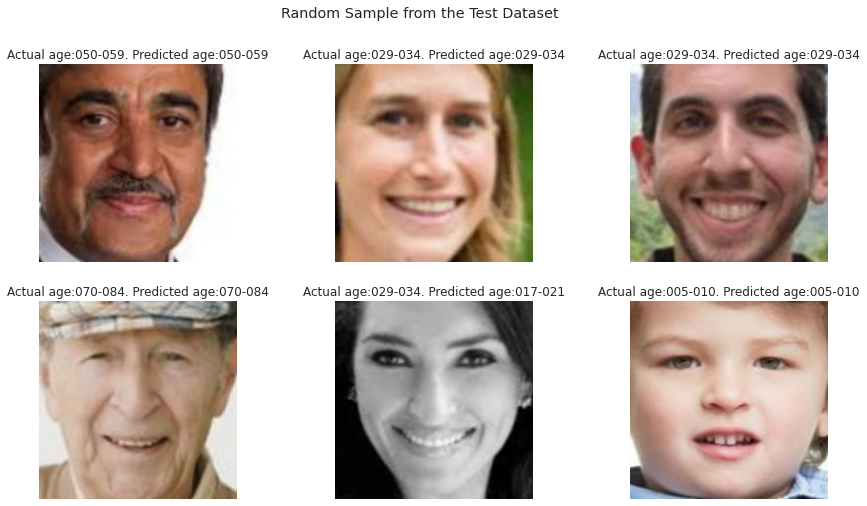

In [ ]:
# generate random sample from the test dataset
n = random.sample(range(0, len(test_files)), 6)

fig = plt.figure(figsize=(15,8))
fig.suptitle('Random Sample from the Test Dataset')
for i, j in enumerate(n):
  axs = fig.add_subplot(2,3,i+1)
  img_test = plt.imread(test_dir+'/'+filenames[j])
  axs.set_title(f"Actual age:{filenames[j].split('/')[0]}. Predicted age:{test_predictions[j]}")
  plt.imshow(img_test)
  plt.axis('off')

plt.show()

Almost all predictions are made correctly. As assumed during the CNN model, there are some chances of misclassification when it comes to black and white images.

#### Additional Testing

In [ ]:
# !pip install face_recognition

In [ ]:
import face_recognition

In [ ]:
image_1 = face_recognition.load_image_file('Tom_Hanks.PNG') # actual age 65
image_1 = image_1/255
image_1 = transform.resize(image_1, (100, 100, 3))
image_1 = np.expand_dims(image_1, axis=0)
tensor_to_img = np.squeeze(image_1)

# prediction
pred_1 = base_model.predict(image_1)
pred_dict = {x : float(y) for x,y in zip(labels, pred_1[0])}
pred_age_1 = max(pred_dict, key=pred_dict.get)

Predicted age range:  060-069


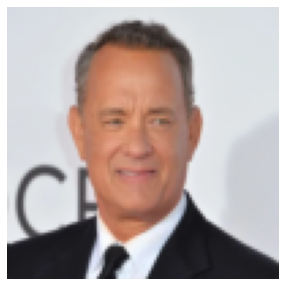

In [ ]:
fig = plt.figure(figsize=(5,5))
print('Predicted age range: ',pred_age_1)
plt.imshow(tensor_to_img)
plt.axis('off')
plt.show()

The range of age that Tom Hanks belongs to is also identified correctly by the ResNet50 model.